<a href="https://colab.research.google.com/github/NayelySaldivar/DAPT_APR2021/blob/main/WorkflowML_%26_FeatureEng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

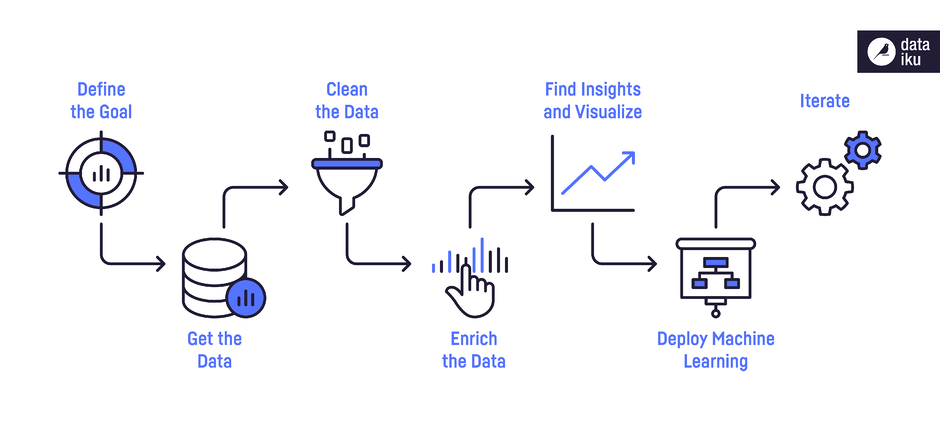

In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
from random import sample 

# Feature Engineering

Es el proceso de extraer características de datos sin procesar mediante técnicas de minería de datos. 

Estas funciones se pueden utilizar para mejorar el rendimiento de los algoritmos de aprendizaje automático.

https://feature-engine.readthedocs.io/en/latest/index.html

In [264]:
!pip install feature_engine

Cargamos la BD:

In [265]:
# from google.colab import drive
# drive.mount('/content/drive')

In [372]:
census = pd.read_csv('/content/census.csv')

# Exploración Inicial del Dataset

In [267]:
census.head(3)

CensusId    State   County  ...  SelfEmployed  FamilyWork  Unemployment
0      1001  Alabama  Autauga  ...           5.5         0.0           7.6
1      1003  Alabama  Baldwin  ...           5.8         0.4           7.5
2      1005  Alabama  Barbour  ...           7.3         0.1          17.6

[3 rows x 37 columns]

In [268]:
census.shape

(3220, 37)

In [269]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusId         3220 non-null   int64  
 1   State            3220 non-null   object 
 2   County           3220 non-null   object 
 3   TotalPop         3220 non-null   int64  
 4   Men              3220 non-null   int64  
 5   Women            3220 non-null   int64  
 6   Hispanic         3220 non-null   float64
 7   White            3220 non-null   float64
 8   Black            3220 non-null   float64
 9   Native           3220 non-null   float64
 10  Asian            3220 non-null   float64
 11  Pacific          3220 non-null   float64
 12  Citizen          3220 non-null   int64  
 13  Income           3219 non-null   float64
 14  IncomeErr        3219 non-null   float64
 15  IncomePerCap     3220 non-null   int64  
 16  IncomePerCapErr  3220 non-null   int64  
 17  Poverty       

# Tratamiento de nulos

In [373]:
# Listado con columnas de datos nulos
column_with_nan = census.columns[census.isnull().any()]
column_with_nan

Index(['Income', 'IncomeErr', 'ChildPoverty'], dtype='object')

In [375]:
census.isnull().sum()[census.isnull().sum() > 0]

Income          1
IncomeErr       1
ChildPoverty    1
dtype: int64

In [272]:
df_null = census[census.Income.isnull() | census.ChildPoverty.isnull()][['Income', 'IncomeErr', 'ChildPoverty']]
df_null

Income  IncomeErr  ChildPoverty
548   66250.0     9909.0           NaN
2673      NaN        NaN           0.0

## Missing Indicator

Es una variable binaria adicional que nos indica si existe un dato faltante en una observación (1) o no (0)

Útil para variables categóricas y numéricas

Se usa junto con métodos que suponen que faltan datos al azar

**Ventajas**:

1.    Fácil de implementar
2.    Captura la importancia de los datos faltantes

**Desventajas**:
1.    Crea nuevas columnas
2.    La variable original debe de imputar datos faltantes

In [273]:
from feature_engine import imputation as mdi

missing_ind = mdi.AddMissingIndicator()

In [274]:
temp = missing_ind.fit_transform(df_null)

In [275]:
temp

Income  IncomeErr  ...  IncomeErr_na  ChildPoverty_na
548   66250.0     9909.0  ...             0                1
2673      NaN        NaN  ...             1                0

[2 rows x 6 columns]

## Mean - Median Imputation

Consiste en **reemplazar todos los datos faltantes** de una variable por la **media** o la **mediana** de la variable.
<br>
<br>
¿Cúando debemos usar la media y cuando la mediana? <br>
Sí los datos están normalmente distribuidos la media y la mediana son aproximadamente iguales.

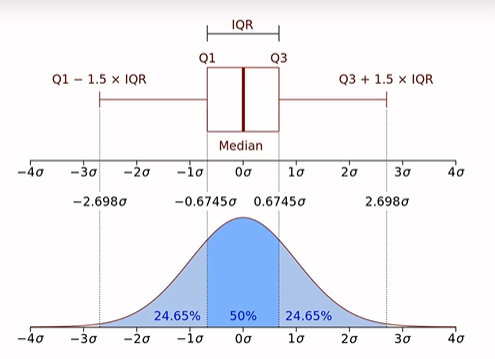


Sí los datos están sesgados, la mediana es una mejor opción

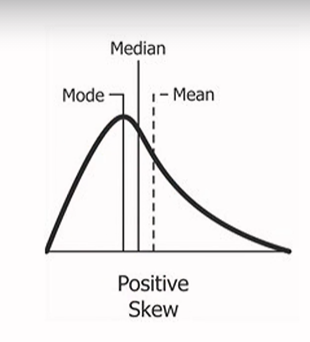


**Ventajas**:

1.    Fácil de implementar.
2.    Manera rápida de completar los datasets.

**Desventajas**:

1.    Distorsiona la distribución de la variable original.
2.    Distorsiona la varianza original.
3.    Entre mayor sea la proporción de datos nulos, mayor es la distorsión.

*¿Cuándo debemos utilizarla?* <br>
Es una buena aproximación cuando tenemos como máximo el 5% de datos son nulos.

El valor de la media o la mediana debe calcularse solamente en el data set de entrenamiento para reemplazar datos nulos en el dataset de entrenamiento y en el data set de prueba para evitar over-fitting.

In [276]:
census[column_with_nan].describe()

Income     IncomeErr  ChildPoverty
count    3219.000000   3219.000000   3219.000000
mean    46129.868903   2850.395464     24.180801
std     12911.297940   1918.942273     11.698329
min     10499.000000    270.000000      0.000000
25%     38191.500000   1635.000000     16.300000
50%     44749.000000   2406.000000     22.700000
75%     52074.000000   3446.000000     30.000000
max    123453.000000  21355.000000     81.600000

In [277]:
imp = mdi.MeanMedianImputer(imputation_method='median')
imp.fit(census[column_with_nan])

MeanMedianImputer(imputation_method='median', variables=None)

In [278]:
imp.imputer_dict_

{'ChildPoverty': 22.7, 'Income': 44749.0, 'IncomeErr': 2406.0}

In [279]:
df_null

Income  IncomeErr  ChildPoverty
548   66250.0     9909.0           NaN
2673      NaN        NaN           0.0

In [280]:
temp = imp.transform(df_null)
temp

Income  IncomeErr  ChildPoverty
548   66250.0     9909.0          22.7
2673  44749.0     2406.0           0.0

## Categorical Imputation

El metodo consiste en tratar los datos nulos como una etiqueta más de la variable, es decir que todos los datos faltantes se agruparían con la etiqueta *missing*.

**Ventajas**:

1.    Fácil de implementar
2.    Captura la importancia de los "datos nulos" si es que existe alguna.

**Desventajas**:
1.    Sí los datos faltantes son pocos y la variable presenta alta cardinalidad 

In [281]:
df_null_cat = pd.DataFrame(census.County[:5])
df_null_cat

County
0  Autauga
1  Baldwin
2  Barbour
3     Bibb
4   Blount

In [282]:
df_null_cat['County_null'] = np.where(df_null_cat['County'] == 'Baldwin', np.nan, df_null_cat['County'])

In [283]:
df_null_cat

County County_null
0  Autauga     Autauga
1  Baldwin         NaN
2  Barbour     Barbour
3     Bibb        Bibb
4   Blount      Blount

In [284]:
imp = mdi.CategoricalImputer(fill_value='Sin_Info')

In [285]:
temp = imp.fit_transform(df_null_cat)
temp.head()

County County_null
0  Autauga     Autauga
1  Baldwin    Sin_Info
2  Barbour     Barbour
3     Bibb        Bibb
4   Blount      Blount

## Eliminación manual

In [286]:
census.shape

(3220, 37)

In [287]:
census.dropna(inplace = True)
census.shape

(3218, 37)

# Revisión de Outliers

¿Por qué es importante tratar los datos atípicos? <br>
El problema radica en que son elementos que pueden no ser representativos de la población y por ende, pueden llegar a distorsionar los resultados de la misma en algunas pruebas estadísticas. 

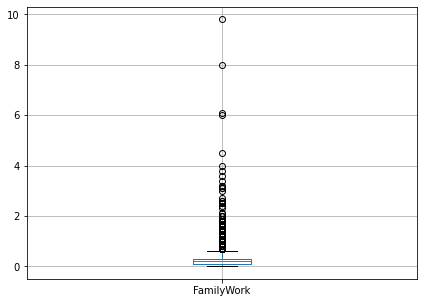

In [288]:
plt.figure(figsize=(7,5))
census.boxplot(column=['FamilyWork'])
plt.show()

In [289]:
q1, q3 = np.percentile(census.FamilyWork, [25,75] )
iqr = q3 - q1
upper = q3 + (3*iqr)
lower = q1 - (3*iqr)

In [290]:
upper

0.8999999999999999

In [291]:
lower 

-0.5

In [292]:
census_clean = census.loc[census.FamilyWork < upper].copy()

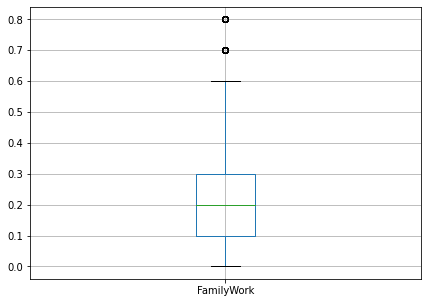

In [293]:
plt.figure(figsize=(7,5))
census_clean.boxplot(column=['FamilyWork'])
plt.show()

In [294]:
print(f'Shape inicial: {census.shape} \nShape final:{census_clean.shape}')

Shape inicial: (3218, 37) 
Shape final:(3020, 37)


# Cambio de Dimensión en Variables
Permite podemos evaluar y comparar los resultados de múltiples modelos ya que nos ayuda a que el entrenamiento del modelo sea menos sensible a la escala de las caracteristicas y esto ayudará a resolver mejor los coeficientes sin que una variable *pese más que otra*.

## Reescalar variables manualmente
La manera más fácil de tranformar variables que están en la misma escala.

In [295]:
# Definiendo las columnas que en mi dataset van de 0 a 100 para escalar
conversion=['Hispanic','White', 'Black', 'Native', 'Asian', 'Pacific', 'Poverty', 'Service', 'Office']

def escala(x):
    return(x/100).round(3)

In [296]:
# Renombrar columnas
n_columns = [ x + 'Rate' for x in conversion]
census_clean[n_columns] = census_clean[conversion].apply(escala)

In [297]:
census_clean[['Black','BlackRate']] .head()

Black  BlackRate
0   18.5      0.185
1    9.5      0.095
2   46.7      0.467
3   21.4      0.214
4    1.5      0.015

## Estandarización de variables <br>
 1. Compara características que tengan diferentes unidades o escalas.
 2. Tiende a que los procesos de entrenamiento se comporten de una mejor manera.

### StandardScaler: <br>
Resta la media y divide entre la desviación estándar de los datos buscando que queden con **media 0 y varianza 1**. <br>
Puedes utilizarlo cuando tus datos tienen distribución normal.

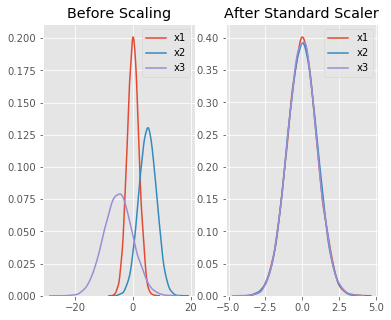

In [298]:
from  sklearn.preprocessing import StandardScaler

scale = StandardScaler()
census_clean['TotalPopStandardScaler'] = scale.fit_transform(census_clean.TotalPop.values.reshape(-1,1))
census_clean.TotalPopStandardScaler.describe().round(2)

count    3020.00
mean       -0.00
std         1.00
min        -0.32
25%        -0.28
50%        -0.23
75%        -0.10
max        30.21
Name: TotalPopStandardScaler, dtype: float64

### Min-Max Scaler <br>
Transformar cada valor de la columna entre un rango de [0,1] <br>
Se puede utilizar cuando tu data está acotada, es decir que conoces lo límites superior e inferior.

In [299]:
from sklearn.preprocessing import MinMaxScaler

census_clean['TotalPopMinMaxScaler'] = MinMaxScaler().fit_transform(census_clean.TotalPop.values.reshape(-1,1))
census_clean.TotalPopMinMaxScaler.describe()

count    3020.000000
mean        0.010478
std         0.032757
min         0.000000
25%         0.001265
50%         0.002822
75%         0.007227
max         1.000000
Name: TotalPopMinMaxScaler, dtype: float64

In [300]:
census_clean.TotalPop.describe()

count    3.020000e+03
mean     1.054501e+05
std      3.288140e+05
min      2.670000e+02
25%      1.296225e+04
50%      2.859550e+04
75%      7.281450e+04
max      1.003839e+07
Name: TotalPop, dtype: float64

In [301]:
census_clean[['TotalPop','TotalPopStandardScaler','TotalPopMinMaxScaler']]

TotalPop  TotalPopStandardScaler  TotalPopMinMaxScaler
0        55221               -0.152784              0.005475
1       195121                0.272755              0.019411
2        26932               -0.238831              0.002656
3        22604               -0.251996              0.002225
4        57710               -0.145213              0.005722
...        ...                     ...                   ...
3215     56858               -0.147804              0.005638
3216      9130               -0.292980              0.000883
3217     24685               -0.245666              0.002433
3218     36279               -0.210400              0.003588
3219     39474               -0.200682              0.003906

[3020 rows x 3 columns]

# Codificación de variables
Nos ayuda a tranformar variables categóricas en numéricas para así incluirlas en los modelos que requieran estos tipos.

**Ventajas:** 
1.   Son faciles de implementar
2.   No requieren horas de exploración

## Variables Dummy
Crea otras columnas adicionales (de 0's y 1's) para cada valor dentro de una columna categórica.

In [302]:
len(census.State.unique())

52

In [303]:
estados = pd.get_dummies(census_clean.State)
census_dummy = pd.concat([census_clean,estados],axis=1).copy()

len(estados.columns)

52

In [304]:
census_dummy.columns.values

array(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional',
       'Service', 'Office', 'Construction', 'Production', 'Drive',
       'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment', 'HispanicRate',
       'WhiteRate', 'BlackRate', 'NativeRate', 'AsianRate', 'PacificRate',
       'PovertyRate', 'ServiceRate', 'OfficeRate',
       'TotalPopStandardScaler', 'TotalPopMinMaxScaler', 'Alabama',
       'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
       'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachu

In [305]:
census_dummy[['State','Alabama']]

State  Alabama
0         Alabama        1
1         Alabama        1
2         Alabama        1
3         Alabama        1
4         Alabama        1
...           ...      ...
3215  Puerto Rico        0
3216  Puerto Rico        0
3217  Puerto Rico        0
3218  Puerto Rico        0
3219  Puerto Rico        0

[3020 rows x 2 columns]

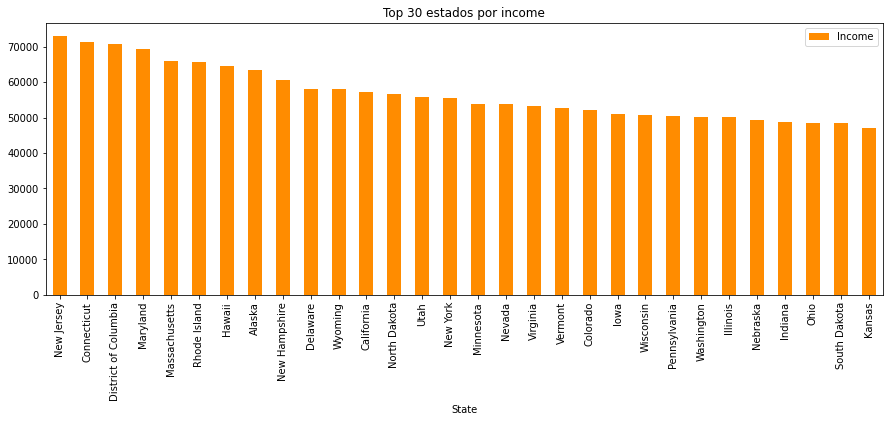

In [306]:
# Graficamos por estados que tienen un mayor income

fig = plt.figure(figsize=(15,5))
ax = fig.gca()
census_dummy.groupby('State')[['Income']].mean().sort_values('Income',ascending = False).head(30).plot.bar(ax=ax, color='darkorange')
ax.set_title('Top 30 estados por income');

## One Hot Encoding
Similiar a *get_dummies*, crea un array con columnas de 0's y 1's. 
Está dentro de la librería sklearn.

In [307]:
from sklearn.preprocessing import OneHotEncoder

In [308]:
onehot_encoder = OneHotEncoder(sparse = False)
onehot_encoded = onehot_encoder.fit_transform(census_clean.State.values.reshape(-1,1))

In [309]:
onehot_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## One Hot Encoding - Top Categories
**Ventajas**:

1.   No expande demasiado el número de las columnas
2.   Maneja nuevas categorías en el test-set (las categorías que no son vistas en el dataset de entrenamiento las toma como 0 en cualquiera de las categorías frecuentes, lo que significa que nuevas categorías no afectaran al modelo)
3.   Sirve para modelos de regresión lineal

**Desventajas**:

1.   No mantiene la información de las etiquetas ignoradas.

Nota: El número categorías top lo seleccionas de manera arbitraria (top5, top10, top100)


In [310]:
from feature_engine.encoding import OneHotEncoder

In [311]:
temp = census[['State','County']]

for col in temp.columns:
  print(col, ": ", len(temp[col].unique()), " etiquetas")

State :  52  etiquetas
County :  1926  etiquetas


In [312]:
temp['County'].sort_values(ascending=False).value_counts().head(10)

Washington    31
Jefferson     26
Franklin      25
Jackson       24
Lincoln       24
Madison       20
Clay          18
Union         18
Montgomery    18
Monroe        17
Name: County, dtype: int64

In [313]:
one_hot_top = OneHotEncoder(top_categories = 10, variables=['County', 'State'])

one_hot_top.fit(temp)

OneHotEncoder(drop_last=False, drop_last_binary=False, ignore_format=False,
              top_categories=10, variables=['County', 'State'])

In [314]:
one_hot_top.encoder_dict_

{'County': ['Washington',
  'Jefferson',
  'Franklin',
  'Jackson',
  'Lincoln',
  'Madison',
  'Clay',
  'Union',
  'Montgomery',
  'Marion'],
 'State': ['Texas',
  'Georgia',
  'Virginia',
  'Kentucky',
  'Missouri',
  'Kansas',
  'Illinois',
  'North Carolina',
  'Iowa',
  'Tennessee']}

In [315]:
one_hot_top.transform(temp).head(4)

County_Washington  County_Jefferson  ...  State_Iowa  State_Tennessee
0                  0                 0  ...           0                0
1                  0                 0  ...           0                0
2                  0                 0  ...           0                0
3                  0                 0  ...           0                0

[4 rows x 20 columns]

## Frequency Encoding

Las categorías son reemplazadas por el **conteo o porcentaje de observaciones** que se encuentran en esa categoría. 

- Captura la representación de cada etiqueta en el dataset
- Popular en competencias de kaggle (:

**Limitaciones**:
Las categorías que comparten el mismo conteo o porcentaje de observaciones tendrán la misma etiqueta.
<br>
<br>

**Ventajas**:
1.    No genera más columnas

**Desventajas**:
1.    No es muy bueno en modelos de regresión lineal
2.    Se puede perder información valiosa de las diferentes categorías


In [316]:
from feature_engine.encoding import CountFrequencyEncoder

In [317]:
temp = census[['State','County']]

In [318]:
count_enc = CountFrequencyEncoder(encoding_method='count')
count_enc.fit_transform(temp)

State  County
0        67       1
1        67       2
2        67       2
3        67       2
4        67       2
...     ...     ...
3215     78       1
3216     78       1
3217     78       1
3218     78       1
3219     78       1

[3218 rows x 2 columns]

In [319]:
count_enc = CountFrequencyEncoder(encoding_method='frequency')
count_enc.fit_transform(temp)

State    County
0     0.020820  0.000311
1     0.020820  0.000622
2     0.020820  0.000622
3     0.020820  0.000622
4     0.020820  0.000622
...        ...       ...
3215  0.024239  0.000311
3216  0.024239  0.000311
3217  0.024239  0.000311
3218  0.024239  0.000311
3219  0.024239  0.000311

[3218 rows x 2 columns]

##Label Encoding: 
Asigna un valor a cada opción de una columna categórica (va transformando según encuentre las categorías) <br>
**Ventajas**: <br>
No genera más columnas y es fácil de implementar

In [320]:
from sklearn import preprocessing

In [321]:
le = preprocessing.LabelEncoder()

In [322]:
temp_label = pd.DataFrame(le.fit_transform(census_clean.State), census_clean.State).T
temp_label


State  Alabama  Alabama  Alabama  ...  Puerto Rico  Puerto Rico  Puerto Rico
0            0        0        0  ...           39           39           39

[1 rows x 3020 columns]

## Ordered Ordinal Encoding / Target Guided Ordinal Encoding

Reemplaza las categorias por enteros entre 1 a k (donde k es el número de categorías distintas en la variables) pero se **enumeran de manera informada** siguiendo la media de la variable dependiente para cada categoría.

**Ventajas**:
1.    No agrega columnas adicionales
2.    Crea relaciones monótonas entre las categorías y la variable dependiente

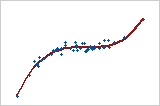

**Desventajas**:

1.    Puede causar over-fitting
2.    Díficil de implementar utilizando validación cruzada

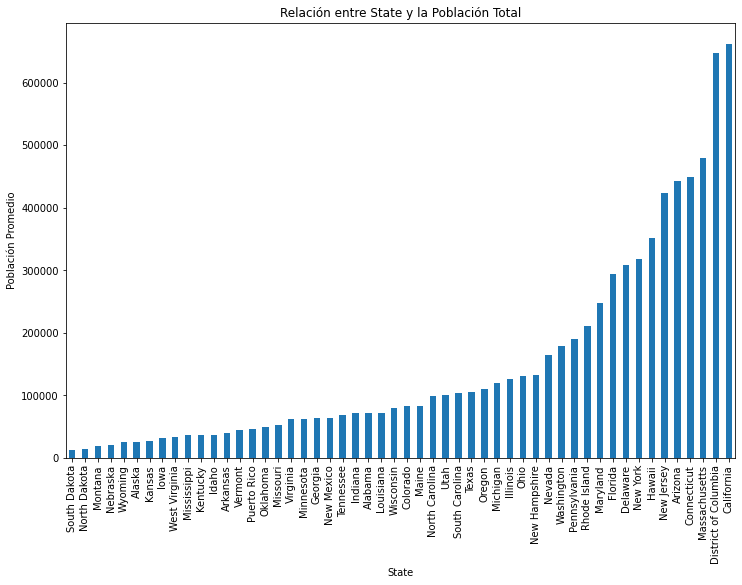

In [323]:
fig = plt.figure(figsize=(12,8))
fig = census.groupby(['State'])['TotalPop'].mean().sort_values().plot(kind='bar')
fig.set_title(f'Relación entre State y la Población Total')
fig.set_ylabel('Población Promedio')
plt.show()

In [324]:
from feature_engine.encoding import OrdinalEncoder

ordinal_enc = OrdinalEncoder(encoding_method='ordered')

In [325]:
# NOTA: SE NECESITA HACER FIT CON LOS DATOS DE ENTRENAMIENTO Y LA VARIABLE DEPENDIENTE (TARGET)

ordinal_enc.fit_transform(temp, census['TotalPop'])

State  County
0        23    1291
1        23    1584
2        23     767
3        23    1482
4        23    1497
...     ...     ...
3215     14    1303
3216     14     343
3217     14     846
3218     14    1051
3219     14    1110

[3218 rows x 2 columns]

## Rare Label Encoding

Ideal para esas categorias que aparecen en pequeñas proporciones de las observaciones en un dataset pero pueden causar problemas de overfitting si se utilizan para entrenar los modelos y tambien ruido en los datasets de prueba.

Posibles escenarios:
1.   Variables que contienen más de dos etiquetas y nos quedamos con las de mayor proporcion, ejemplo:<br>
   azul : 0.60,   rojo : 0.30,   verde : 0.01.   amarillo : 0.09

   Lo tranforma a:<br>
   azul : 0.60,   rojo : 0.30,   raras : 0.10

3.   Variables con alta cardinalidad que necesitamos agrupar

**Ventajas**:
1.    Las categorías nuevas que aparezcan en el dataset de pruebas serán agrupadas como "raras"

**Desventajas**:
1.    Las categorías que se agrupan como raras pueden perder importancia

In [326]:
from feature_engine.encoding import RareLabelEncoder

In [327]:
temp_df = pd.Series(temp['State'].value_counts() / len(temp))
temp_df.head(3)

Texas       0.07862
Georgia     0.04941
Virginia    0.04133
Name: State, dtype: float64

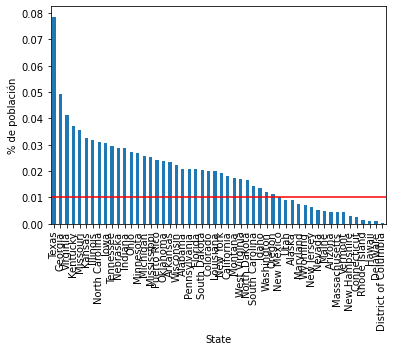

In [328]:
  fig = temp_df.sort_values(ascending=False).plot.bar()
  fig.set_xlabel('State')
  fig.axhline(y=0.01, color='red')
  fig.set_ylabel('% de población')
  plt.show()

In [329]:
rare_encoder = RareLabelEncoder(tol=0.01, variables=['State'])

In [330]:
df_rare = rare_encoder.fit_transform(temp)

In [331]:
df_rare.State.value_counts()

Texas             253
Rare              233
Georgia           159
Virginia          133
Kentucky          120
Missouri          115
Kansas            105
Illinois          102
North Carolina    100
Iowa               99
Tennessee          95
Nebraska           93
Indiana            92
Ohio               88
Minnesota          87
Michigan           83
Mississippi        82
Puerto Rico        78
Oklahoma           77
Arkansas           75
Wisconsin          72
Florida            67
Alabama            67
Pennsylvania       67
South Dakota       66
Colorado           64
Louisiana          64
New York           62
California         58
Montana            56
West Virginia      55
North Dakota       53
South Carolina     46
Idaho              44
Washington         39
Oregon             36
New Mexico         33
Name: State, dtype: int64

# Discretización de variables

Es el proceso de transformar una variable continua en una variable discreta
creando un conjunto de intervalos contiguos que abarcan el rango del valor de las variables. *También es llamado binning*
<br>
<br>
**Ventajas:** <br>
1.- Puede mejorar la distribución de los datos sesgados <br>
2.- Buen manejo de outliers sin perder información


Existen diferentes métodos para hacer estas transformaciones:

- Supervisados
  - Decision trees

- No supervisados:
  - Equal-width 
  - Equal-frequency
  - K means

## Equal - Frequency discretisation

Divide el alcance de los posibles valores de las variables en N contenedores, con la misma cantidad de observaciones en cada uno, ie, distribuye los valores de manera homogenea.

Los limites de los intervalos corresponden a los **cuantiles**, los intervalos se determinan de manera arbitraria. 


In [332]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

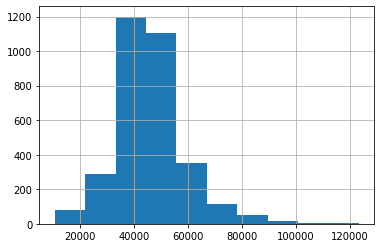

In [333]:
temp_pob = census[['TotalPop','Income']]
temp_pob.Income.hist()
plt.show()

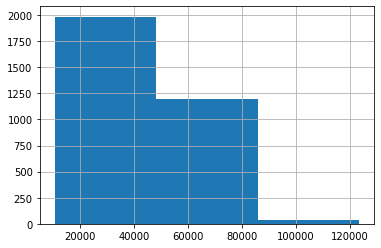

In [334]:
temp_pob.Income.hist(bins = 3)
plt.show()

In [335]:
disc = EqualFrequencyDiscretiser(q = 5, variables=['Income'])

In [336]:
disc.fit_transform(temp_pob).head()

TotalPop  Income
0     55221       3
1    195121       3
2     26932       0
3     22604       1
4     57710       2

In [337]:
disc.binner_dict_

{'Income': [-inf, 36602.6, 42170.8, 47690.4, 54088.4, inf]}

In [338]:
temp_pob.head(5)

TotalPop   Income
0     55221  51281.0
1    195121  50254.0
2     26932  32964.0
3     22604  38678.0
4     57710  45813.0

# Sección del dataset

### Sampling <br>
Toma muestras aleatorias del dataset según el tamaño que se indique.

In [339]:
census_clean.shape

(3020, 48)

In [340]:
census_sample_proporcion = census_clean.sample(frac=.5)
census_sample_rows = census_clean.sample(n = 1000)

print(census_sample_proporcion.shape)
print(census_sample_rows.shape)

(1510, 48)
(1000, 48)


In [341]:
census_sample_proporcion.head(2)

CensusId     State  ... TotalPopStandardScaler  TotalPopMinMaxScaler
1521     29077  Missouri  ...               0.540687              0.028186
357      12077   Florida  ...              -0.295520              0.000800

[2 rows x 48 columns]

### Shuffling <br>
Genera cambios aleatorios en el **orden** del dataset y después toma una muestra del tamaño que se le pide.

In [342]:
census_dummy.shape

(3020, 100)

In [343]:
census_dummy.head(3)

CensusId    State   County  ...  West Virginia  Wisconsin  Wyoming
0      1001  Alabama  Autauga  ...              0          0        0
1      1003  Alabama  Baldwin  ...              0          0        0
2      1005  Alabama  Barbour  ...              0          0        0

[3 rows x 100 columns]

In [344]:
s_census = census_dummy.sample(frac = 1).reset_index(drop=True)
s_census.head(3)

CensusId       State    County  ...  West Virginia  Wisconsin  Wyoming
0     17159    Illinois  Richland  ...              0          0        0
1      6035  California    Lassen  ...              0          0        0
2     13071     Georgia  Colquitt  ...              0          0        0

[3 rows x 100 columns]

### Train_test_split() <br>
Librería especializada en dividir nuestro dataset en grupos de entrenamiento y prueba.


In [345]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(census_dummy, train_size=.2)
print(train.shape, test.shape)

(604, 100) (2416, 100)


# Pipeline <br>
Conexión de los diferentes tratamientos utilizados en un solo flujo:

In [346]:
from sklearn.pipeline import Pipeline

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [391]:
census = pd.read_csv('/content/census.csv')

In [394]:
def census_pipe(df):

  print('Tamaño inicial del df ', df.shape)

  # Tratamiento de nulos:
  column_with_nan = census.columns[census.isnull().any()]
  if len(column_with_nan) > 0:
    if  df.isnull().sum().sum()/len(df) < .05:
      df.dropna(inplace = True)
      print('Se eliminaron los nulos, tamaño:',df.shape)
    else:
      imp = mdi.MeanMedianImputer(imputation_method='median', variables= column_with_nan)
      df = imp.fit(df)

  # Outliers en *FamilyWork*:
  q1, q3 = np.percentile(df.FamilyWork, [25,75] )
  iqr = q3 - q1
  upper = q3 + (3*iqr)
  lower = q1 - (3*iqr)
  df_clean = df.loc[df.FamilyWork < upper].copy()
  print('Se eliminaron outliers, tamaño:', df_clean.shape)

  # Cambio de dimensión de variables
  conversion=['Hispanic','White', 'Black', 'Native', 'Asian', 'Pacific', 'Poverty', 'Service', 'Office']
  n_columns = [ x + 'Rate' for x in conversion]
  df_clean[n_columns] = df_clean[conversion].apply(escala)

  # Encoding
  estados = pd.get_dummies(df_clean.State)
  df_dummy = pd.concat([df_clean,estados],axis=1).copy()

  print('El dataset está listo')

  return df_dummy


In [395]:
census_pipe(census)

Tamaño inicial del df  (3218, 37)
Se eliminaron outliers, tamaño: (3020, 37)
El dataset está listo


CensusId        State     County  ...  West Virginia  Wisconsin  Wyoming
0         1001      Alabama    Autauga  ...              0          0        0
1         1003      Alabama    Baldwin  ...              0          0        0
2         1005      Alabama    Barbour  ...              0          0        0
3         1007      Alabama       Bibb  ...              0          0        0
4         1009      Alabama     Blount  ...              0          0        0
...        ...          ...        ...  ...            ...        ...      ...
3215     72145  Puerto Rico  Vega Baja  ...              0          0        0
3216     72147  Puerto Rico    Vieques  ...              0          0        0
3217     72149  Puerto Rico   Villalba  ...              0          0        0
3218     72151  Puerto Rico    Yabucoa  ...              0          0        0
3219     72153  Puerto Rico      Yauco  ...              0          0        0

[3020 rows x 98 columns]

# Creación del modelo

In [396]:
df = census_dummy._get_numeric_data()
df.head(2)

CensusId  TotalPop    Men  ...  West Virginia  Wisconsin  Wyoming
0      1001     55221  26745  ...              0          0        0
1      1003    195121  95314  ...              0          0        0

[2 rows x 98 columns]

Definición de las variables predictoras y el target:

In [403]:
X = df.drop(columns=['TotalPop','CensusId'])
y = df.TotalPop

Construimos los datasets de entrenamiento y prueba:

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

Nosotros haremos una **Regresión Lineal** intentando predecir los la población total:

In [399]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [400]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred=linreg.predict(X_test)

In [401]:
df_predicted = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
df_predicted.head(5)

Actual  Predicted
497    27086    27086.0
1486   25783    25783.0
1380    9563     9563.0
1070   19717    19717.0
2842    5212     5212.0

In [402]:
r2_score(y_test,y_pred)

1.0

#Cross Validation con K-Fold
Medida preventiva contra el overfitting.


Consiste en generar multiples divisiones a partir de nuestros datos para entrenar iterativamente el modelo.


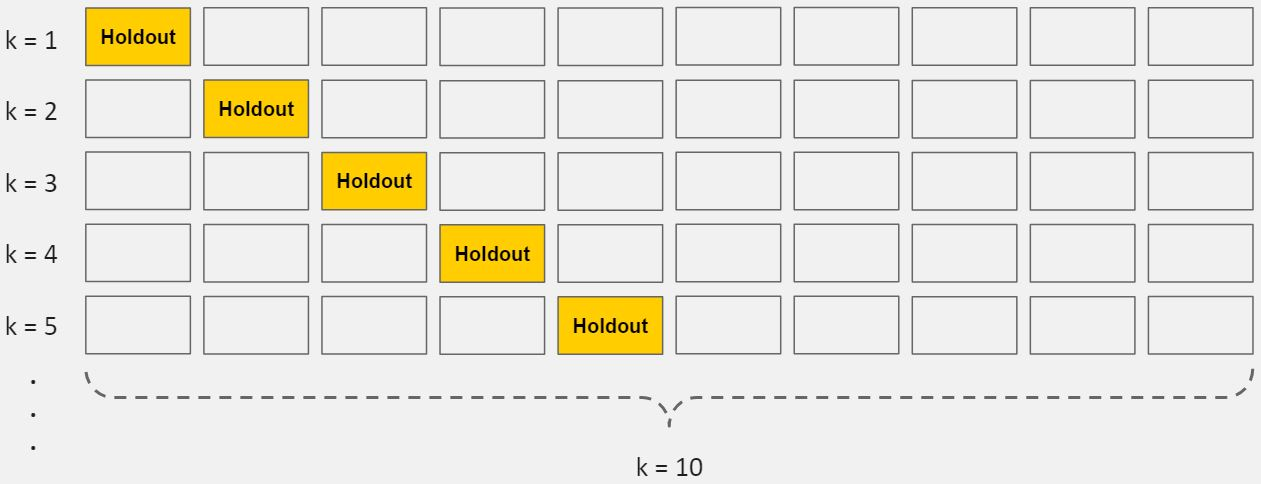

In [355]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score

In [356]:
X = df.drop(columns=['Income','CensusId'])
y = df.Income

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=77)

In [358]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [359]:
y_pred = linreg.predict(X_test)

In [360]:
df_predicted = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_predicted

Actual     Predicted
444   88816.0  78263.771433
1929  35777.0  34189.963359
1601  50115.0  52948.259774
838   55033.0  53283.585166
2617  43375.0  36710.810846
...       ...           ...
458   63824.0  63154.611751
2688  38929.0  45539.833671
2072  40930.0  40069.965791
2069  37319.0  41587.216955
873   50438.0  50304.187760

[604 rows x 2 columns]

In [361]:
r2_score(y_test,y_pred)

0.9009578765534977

## KFold

- Generar 10 pruebas con nuestro dataset original
- Shuffle es para "mezclar" nuestro dataset
- Random_state = para que nuestros resultados sean iguales


In [362]:
kfold = KFold(n_splits = 10, random_state=1, shuffle=True)

Generamos la validación cruzada de nuestra regresión lineal y calculamos su r^2. <br>
(Funciona como un loop para imprimir los coeficientes de la regresión)

In [363]:
cv_r2_scores = cross_val_score(linreg, X, y, cv=kfold, scoring='r2')
print(cv_r2_scores)

[0.92217476 0.90192216 0.91100521 0.92642834 0.92390506 0.89445808
 0.91031041 0.89623393 0.91665917 0.90152752]


Para finalizar, sacamos la media de nuestro **cross_val** para evaluar r^2 de nuestro modelo.

In [364]:
np.mean(cv_r2_scores)

0.910462464938505